# **Import libraries**

In [ ]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Lambda,Flatten
from keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Oxford Dataset**

In [ ]:
input_dir = "/content/drive/MyDrive/data/photos"

In [ ]:
input_img_paths = sorted(
    [os.path.join(input_dir,fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

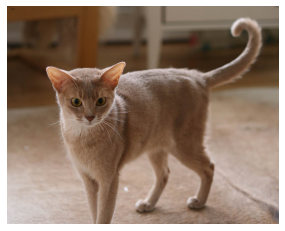

In [ ]:
img = load_img(input_img_paths[20])
plt.axis("off")
plt.imshow(img)

In [ ]:
import numpy as np
import random

img_size = (256,256)
num_imgs = len(input_img_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))
  
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32")

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])


In [ ]:
input_imgs_gray=[]
input_imgs_color=[]
for i in input_img_paths:
    img_gray=cv2.imread(i,0)
    img_color=cv2.imread(i)
    
    if((type(img_gray) == type(None)) and (type(img_color) == type(None))):
        pass
    else:
        img_color=cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        resized_gray = cv2.resize(img_gray, (256,256), interpolation = cv2.INTER_AREA)
        resized_color = cv2.resize(img_color, (256,256), interpolation = cv2.INTER_AREA)

        normalize_gray=(np.asarray(resized_gray).astype('float32')) / 255
        normalize_color=(np.asarray(resized_color).astype('float32')) / 255

        input_imgs_gray.append(normalize_gray)
        input_imgs_color.append(normalize_color)

In [ ]:
import cv2
import os
from os import listdir
dataset=[]
labels=[]
i=0
categories=['category1','category6','category7','category8','category10','category21','category25','category27','category33','category34']
for category in categories:
  for images in os.listdir('/content/drive/MyDrive/oxford-iiit-pet/'+category):
    img=cv2.imread(('/content/drive/MyDrive/oxford-iiit-pet/'+category+'/'+images),0)
    dataset.append(img)
    labels.append(i)
  i+=1

In [ ]:
input_imgs_gray=np.array(input_imgs_gray)
input_imgs_color=np.array(input_imgs_color)

print(input_imgs_gray.shape,input_imgs_color.shape)

(999, 256, 256) (999, 256, 256, 3)


# **Spliting Dataset to Train and Test**

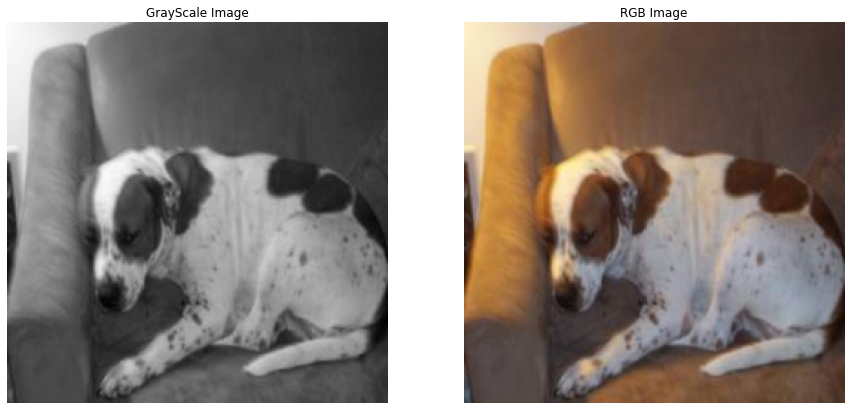

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title("GrayScale Image")
plt.imshow(input_imgs_gray[500],cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("RGB Image")
plt.imshow(input_imgs_color[500])
plt.axis("off")

plt.show()

In [ ]:
x_train=input_imgs_gray[:800]
y_train=input_imgs_color[:800]
x_test=input_imgs_gray[800:]
y_test=input_imgs_color[800:]
x_train=x_train.reshape(len(x_train),256,256,1)
test=x_test.copy()

x_test=x_test.reshape(len(x_test),256,256,1)



print("Train Data", x_train.shape,y_train.shape)
print("Test Data", x_test.shape,y_test.shape)


Train Data (800, 256, 256, 1) (800, 256, 256, 3)
Test Data (199, 256, 256, 1) (199, 256, 256, 3)


# **U-NEt Architecture**

In [ ]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
encoder_output = MaxPooling2D((2, 2))(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = MaxPooling2D((2, 2))(encoder_output)

encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = MaxPooling2D((2, 2))(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                       

In [ ]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,y_train,validation_split=0.1, epochs=150)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy*100," %")

7/7 [==============================] - 2s 272ms/step - loss: 0.0080 - accuracy: 0.6369
Test Loss: 0.008034336380660534
Test Accuracy: 63.68592977523804  %


In [ ]:
Prediction_IMG = model.predict(x_test)

7/7 [==============================] - 1s 109ms/step


In [ ]:
Prediction_IMG.shape

(199, 256, 256, 3)

# **Display Prediction image**

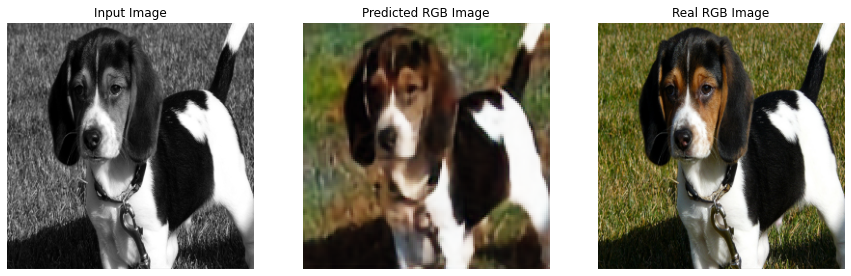

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test[50],cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted RGB Image")
plt.imshow(Prediction_IMG[50])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Original RGB Image")
plt.imshow(y_test[50])
plt.axis("off")
plt.show()